In [1]:
# 📦 Imports
import pandas as pd
import glob

# 📁 Load raw Statcast data
files = sorted(glob.glob("../data/raw/statcast_*.csv"))
dfs = [pd.read_csv(file, low_memory=False) for file in files]
df = pd.concat(dfs, ignore_index=True)

# ✅ Extract season and stadium info
df['season'] = pd.to_datetime(df['game_date']).dt.year
df = df.dropna(subset=['pitcher', 'pitch_type', 'release_speed', 'home_team'])

# 🔎 For simplicity, use home team as stadium for now
df['stadium'] = df['home_team']

# 📁 Load seasonal velocity grades
grades = pd.read_csv("../data/processed/pitcher_velocity_grades.csv")

# 📁 Load role classification (from prior notebook if available)
# You may reuse logic from 07 to get roles by pitcher + season
# For now, recreate quick and simple version
df['game_id'] = df['game_date'].astype(str) + "_" + df['home_team'] + "_" + df['away_team']
df = df.sort_values(by=['season', 'game_id', 'inning', 'pitch_number'])
first_pitchers = df.groupby(['season', 'game_id']).first().reset_index()[['season', 'game_id', 'pitcher']]
starter_counts = first_pitchers.groupby(['season', 'pitcher']).size().reset_index(name='starts')
total_counts = df.groupby(['season', 'pitcher']).size().reset_index(name='total')
roles = pd.merge(total_counts, starter_counts, on=['season', 'pitcher'], how='left').fillna(0)
roles['starts'] = roles['starts'].astype(int)
roles['role'] = roles.apply(lambda row: 'Starter' if row['starts'] >= 5 else 'Reliever', axis=1)

# 🔗 Merge grades, roles, and stadium info
grades = grades.merge(roles[['season', 'pitcher', 'role']], on=['season', 'pitcher'], how='left')
grades = grades.merge(df[['season', 'pitcher', 'stadium']], on=['season', 'pitcher'], how='left')

# 🧼 Drop duplicates (one per pitcher per stadium per season)
grades = grades.drop_duplicates(subset=['season', 'pitcher', 'stadium', 'pitch_type'])

# 📊 Group: how many A/B/C/D/F per stadium per role
grade_counts = pd.get_dummies(grades['velocity_grade'])
grades = pd.concat([grades[['season', 'stadium', 'role']], grade_counts], axis=1)
stadium_summary = grades.groupby(['season', 'stadium', 'role']).sum(numeric_only=True).reset_index()

# 💾 Save
stadium_summary.to_csv("../data/processed/stadium_pitching_grades.csv", index=False)
print("✅ Saved to ../data/processed/stadium_pitching_grades.csv")

# 🔍 Preview
stadium_summary.head()


✅ Saved to ../data/processed/stadium_pitching_grades.csv


,season,stadium,role,A,B,C,D,F
0,2022,ATL,Reliever,235,109,184,77,130
1,2022,ATL,Starter,72,55,126,50,64
2,2022,AZ,Reliever,207,119,184,82,142
3,2022,AZ,Starter,57,59,103,38,109
4,2022,BAL,Reliever,235,111,180,67,150


🏟️ Stadium Pitching Grade Analysis
This section ranks MLB stadiums based on the number of Grade A pitchers who pitched there in a given season, separated by role:

Starters

Relievers

The grade is determined by comparing each pitcher's average pitch velocity (by type) to the league average. A pitcher is awarded a Grade A if they consistently throw ≥2 mph faster than league average for a given pitch type.

📊 Visualizations:
Top 10 Stadiums for Grade A Starters (2022)
Shows which parks hosted the most elite starting pitchers based on velocity.

Top 10 Stadiums for Grade A Relievers (2022)
Highlights parks with the most high-velocity bullpen appearances.

Each bar chart provides insights into where the league's hardest-throwing pitchers tend to appear — revealing trends that may be tied to:

Team roster strengths

Home park advantages

Bullpen usage strategies

C:\Users\belgr\AppData\Local\Temp\ipykernel_55952\3557648089.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='stadium', y=grade, palette='crest')


📁 Saved: ../reports/figures/stadium_grade_A_starters_2022.png


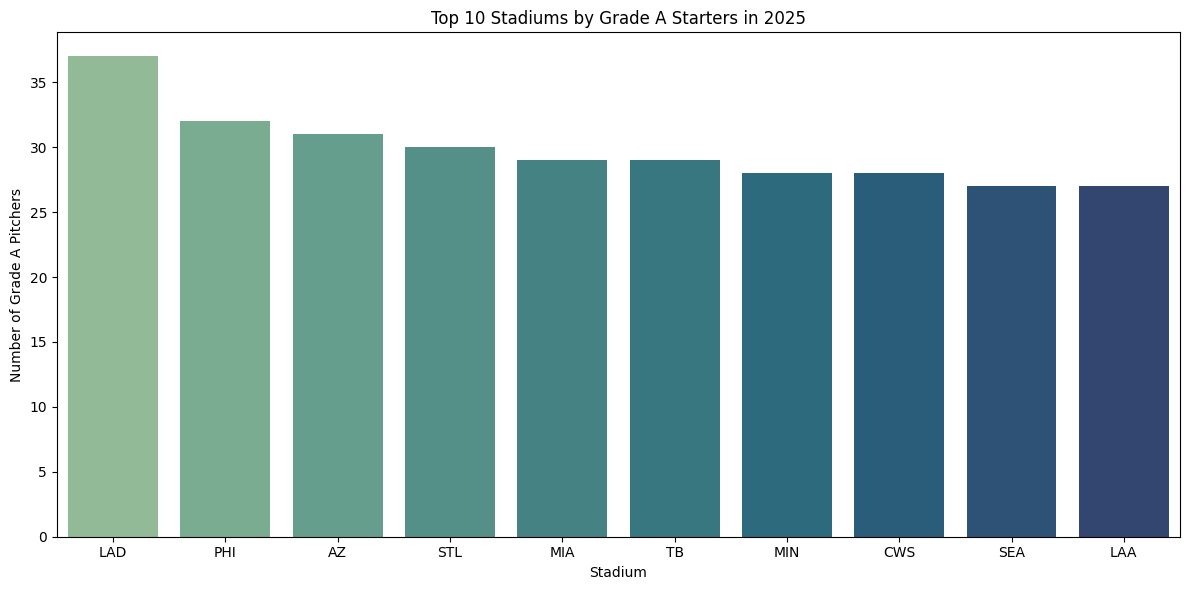

C:\Users\belgr\AppData\Local\Temp\ipykernel_55952\3557648089.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='stadium', y=grade, palette='crest')


📁 Saved: ../reports/figures/stadium_grade_A_relievers_2022.png


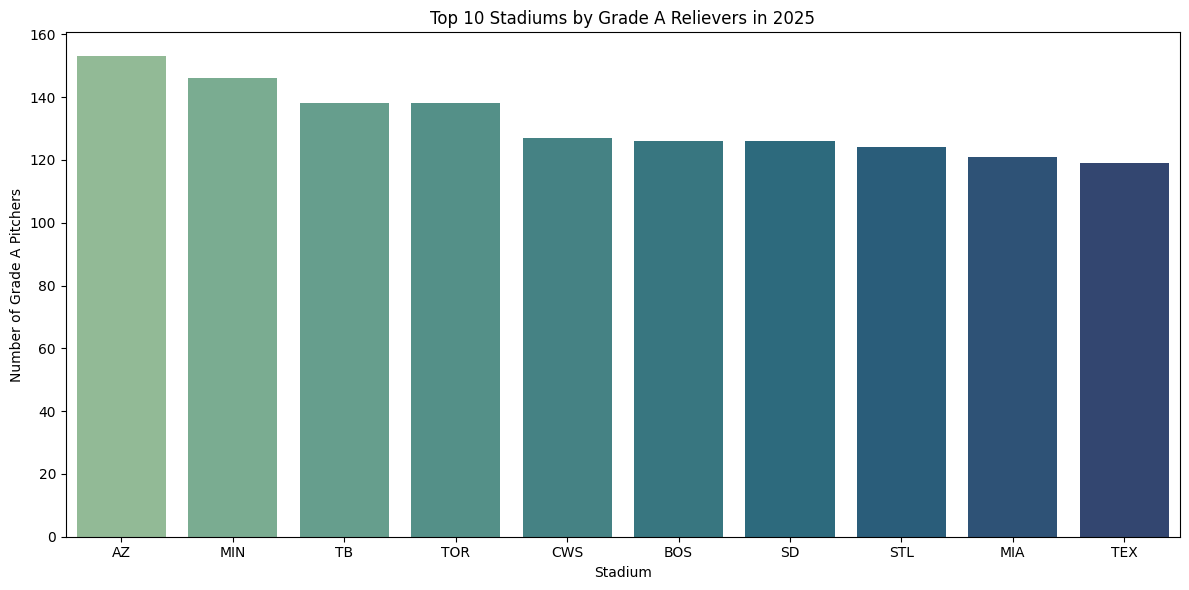

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 Load stadium summary
df = pd.read_csv("../data/processed/stadium_pitching_grades.csv")

# 🎯 Rank by A-grade count for each role
def plot_top_stadiums(data, role, year, grade='A', top_n=10, save_path=None):
    subset = data[(data['role'] == role) & (data['season'] == year)]
    subset = subset.sort_values(by=grade, ascending=False).head(top_n)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=subset, x='stadium', y=grade, palette='crest')
    plt.title(f"Top {top_n} Stadiums by Grade {grade} {role}s in {year}")
    plt.ylabel(f"Number of Grade {grade} Pitchers")
    plt.xlabel("Stadium")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"📁 Saved: {save_path}")
    
    plt.show()

# 📊 Top 10 by role for 2022 (adjust year as needed)
plot_top_stadiums(df, role='Starter', year=2025, save_path="../reports/figures/stadium_grade_A_starters_2022.png")
plot_top_stadiums(df, role='Reliever', year=2025, save_path="../reports/figures/stadium_grade_A_relievers_2022.png")
